# Cluster Analysis

## Time Series Analysis

In the analysis of time series data, the input features are not independent. In this case SVMs and Naive Bayes good choices since they assume that the input features are independent [ref]. The k-NN algorithm could work; it relies on the notion of a similarity measure between input examples. 
How then do we measure the similarity between multiple time series?

Task: 

1. Time-series analysis, clustering and classification - using various similarity measures (DTW, Euclidean) over different clustering algorithms: 
    * EM 
    * GMM
    * DBSCAN

2. Functional data analysis and support-vector machines with various kernels
    * RBF 
    * Nystrom 
    * Fourier

The main objective of the project is to and a clustering that classifes data according to a hierarchical attribute tree, such as water meters and electricity meters, and within that water meters belonging to a particular building, space, etc. Since there is significant complexity involved with the full classification problem, the hierarchy tree depth at which the project focuses is 2 or (max) 3.

## Data Preprocessing

For the purpose of working on the scale of one pc, only one BMS file is examined. Within this file, only one devices of multiple modules is also examined.

In [1]:
import pandas as pd
import glob
import timeit

bms_files = glob.glob('../../Bowland North Model/bms/cluster/*.csv')
bms_meta_df = pd.read_csv('../../Bowland North Model/metadata/planonmeters.csv')

bms_frame_list = []

# timing the loop
start_time = timeit.default_timer()
for file_ in bms_files:
    df = pd.read_csv(file_, header=0)
    df = df[df['device_id'] == '{A69642A1-3855-479C-89F7-DCB47B48FCC0}'] 
    bms_frame_list.append(df)
elapsed = timeit.default_timer() - start_time

bms_df = pd.concat(bms_frame_list)

print("%d rows" % bms_df.shape[0])
print("%.2f seconds" % elapsed)
bms_df.head()

261326 rows
57.83 seconds


,param_name,param_type,param_value,timestamp,device_id,module_key
0,S,1,10.467929,2017-06-01 01:00:00.530000000,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D12
1,S,101,1,2017-06-01 01:00:00.537000000,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D16
2,S,1,54.709999,2017-06-01 01:00:00.543000000,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D2
3,S,101,1,2017-06-01 01:00:00.553000000,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D5
4,S,1,37.408386,2017-06-01 01:00:00.560000000,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D9


## EDA
### Module Key Dimensions

In [2]:
bms_df = bms_df[bms_df['param_value'] != "Invalid"]
print("%d unique modules/sensors" % len(bms_df['module_key'].unique()))
mod_keys = bms_df['module_key'].unique()
bms_df['timestamp'] = pd.to_datetime(bms_df['timestamp'])

136 unique modules/sensors


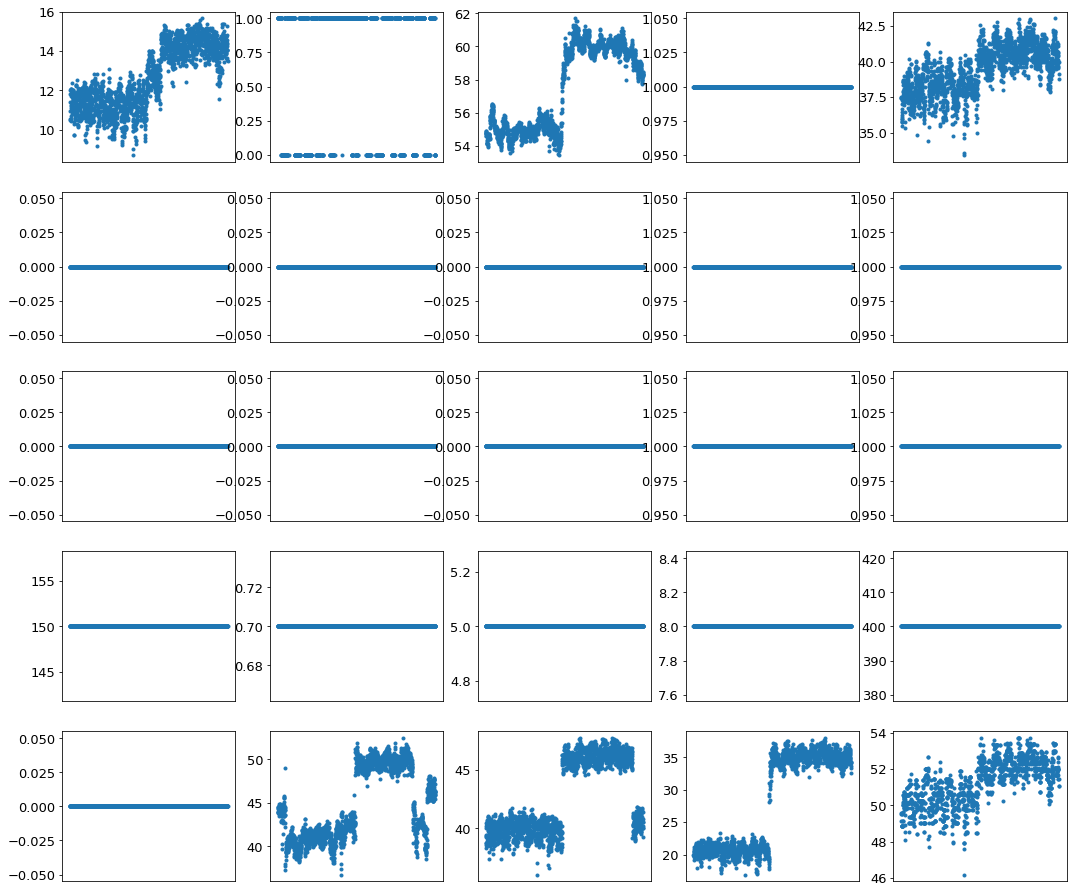

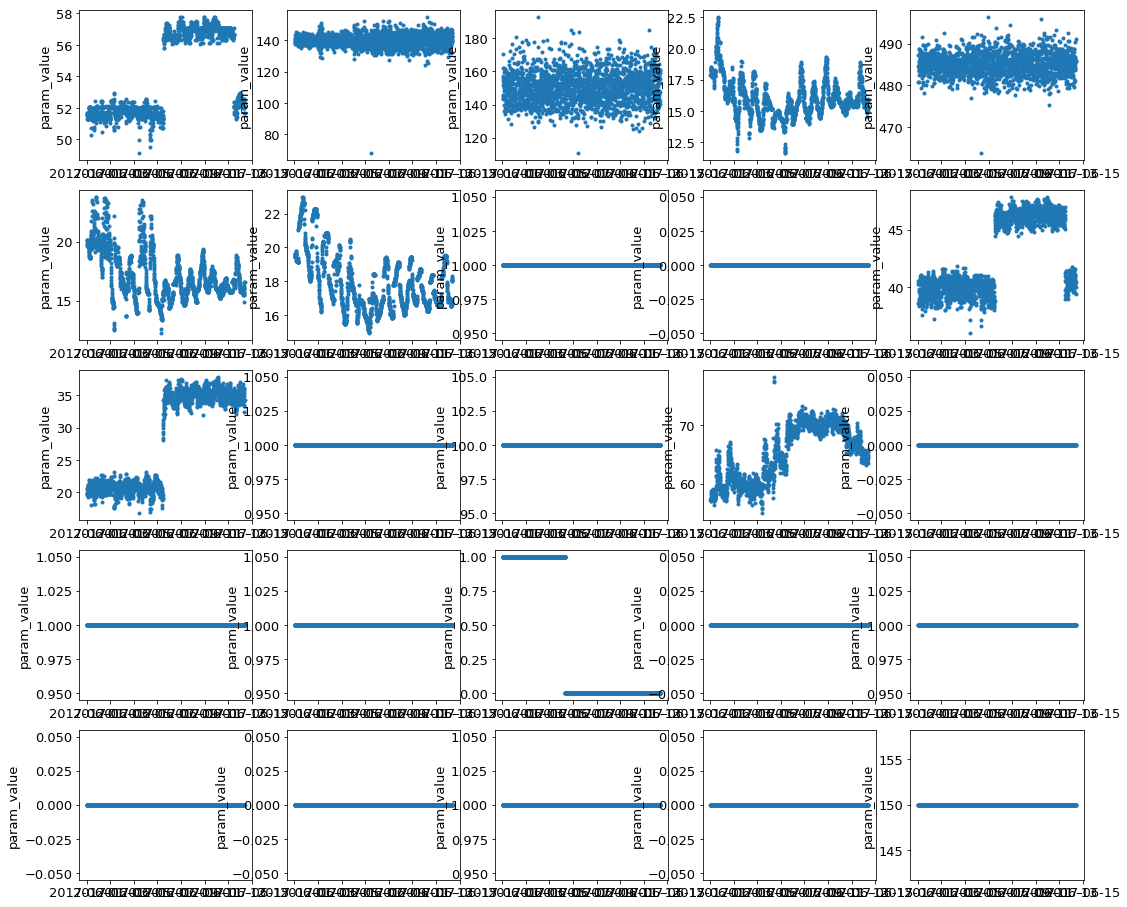

In [5]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

# matplotlib.rcParams.update({'font.size': 12})

i = 1
plt.rcParams["figure.figsize"] = [18, 16]
plt.rcParams['font.size'] = 13
plt.figure(1) 
for mkey in mod_keys[:25]:
    plt.subplot(5, 5, i)
    sensor = bms_df[bms_df.module_key == mkey]
    sensor = sensor[["timestamp", "param_value"]]
    sensor = sensor.sort_values("timestamp")
#     plt.ylabel("param_value")
    
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
    
    plt.plot_date("timestamp", "param_value", ".", data=sensor)
    i += 1
plt.savefig('plots/module_samples_raw.png')
i = 1
plt.figure(2) 
for mkey in mod_keys[25:50]:
    plt.subplot(5, 5, i)
    sensor = bms_df[bms_df.module_key == mkey]
    sensor = sensor[["timestamp", "param_value"]]
    sensor = sensor.sort_values("timestamp")
    plt.ylabel("param_value")
    plt.plot_date("timestamp", "param_value", ".", data=sensor)
    i += 1

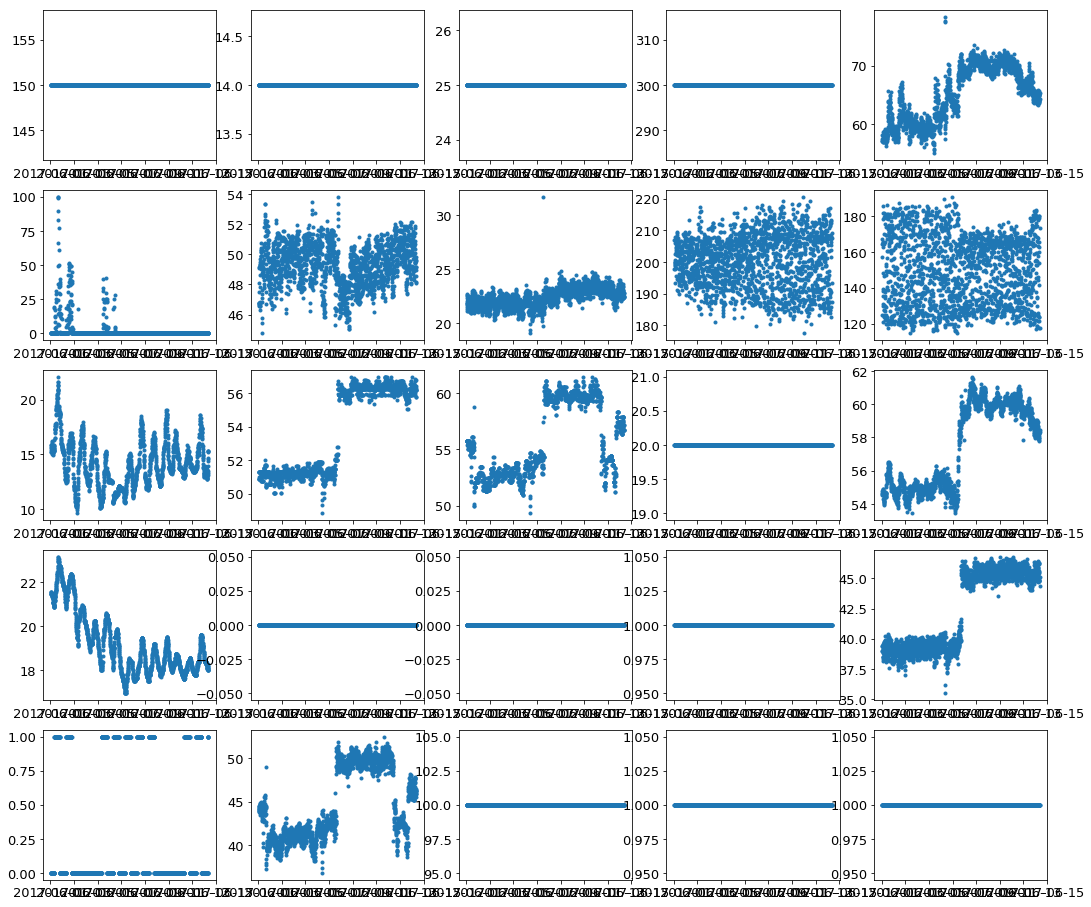

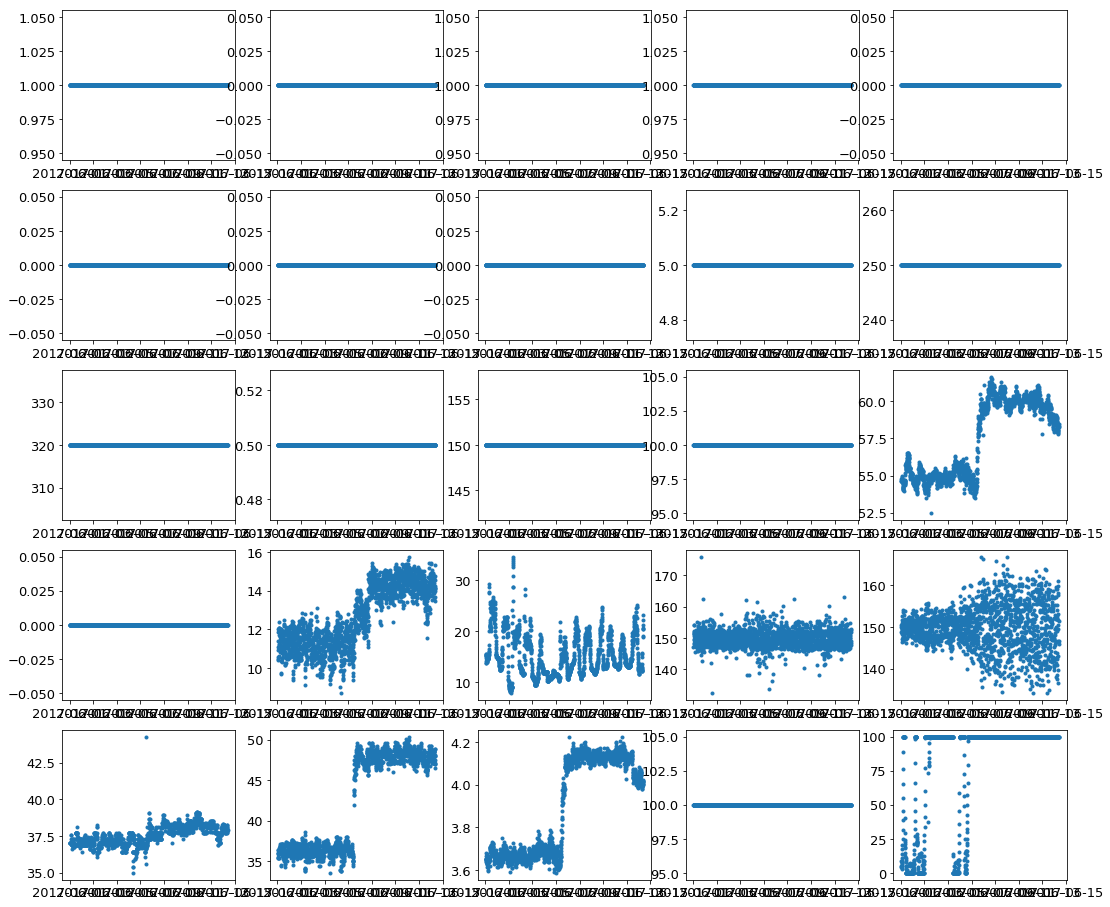

In [6]:
i = 1
plt.figure(1) 
for mkey in mod_keys[50:75]:
    plt.subplot(5, 5, i)
    sensor = bms_df[bms_df.module_key == mkey]
    sensor = sensor[["timestamp", "param_value"]]
    sensor = sensor.sort_values("timestamp")
    plt.plot_date("timestamp", "param_value", ".", data=sensor)
    i += 1

i = 1
plt.figure(2) 
for mkey in mod_keys[75:100]:
    plt.subplot(5, 5, i)
    sensor = bms_df[bms_df.module_key == mkey]
    sensor = sensor[["timestamp", "param_value"]]
    sensor = sensor.sort_values("timestamp")
    plt.plot_date("timestamp", "param_value", ".", data=sensor)
    i += 1

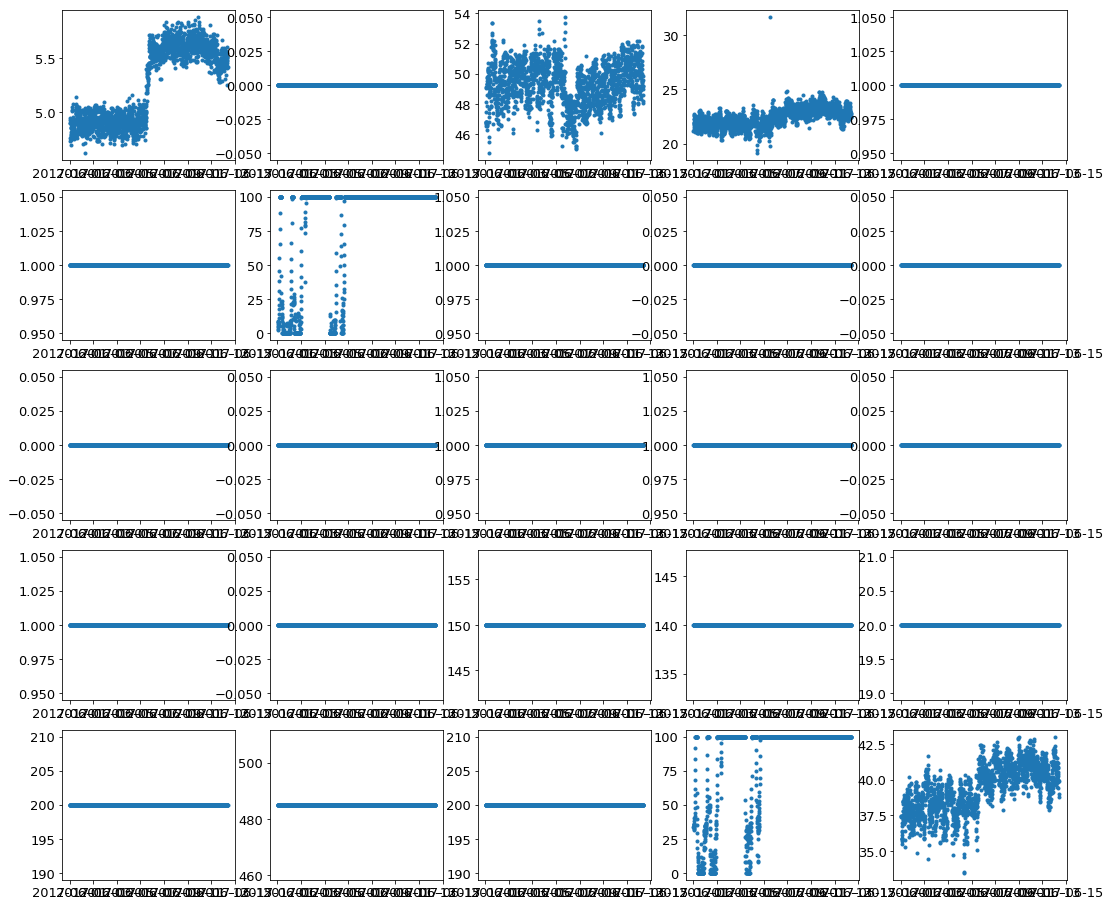

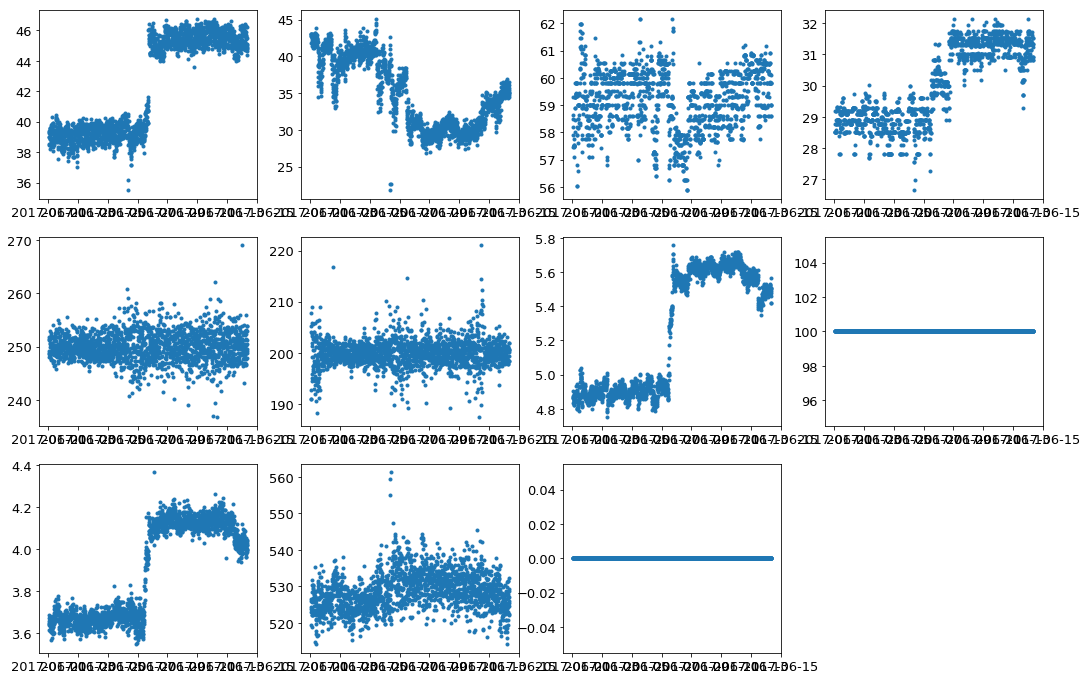

In [7]:
i = 1
plt.figure(1) 
for mkey in mod_keys[100:125]:
    plt.subplot(5, 5, i)
    sensor = bms_df[bms_df.module_key == mkey]
    sensor = sensor[["timestamp", "param_value"]]
    sensor = sensor.sort_values("timestamp")
    sensor = sensor[sensor['param_value'] != 'Invalid']
    plt.plot_date("timestamp", "param_value", ".", data=sensor)
    i += 1

i = 1
plt.figure(2) 
for mkey in mod_keys[125:]:
    plt.subplot(4, 4, i)
    sensor = bms_df[bms_df.module_key == mkey]
    sensor = sensor[["timestamp", "param_value"]]
    sensor = sensor.sort_values("timestamp")
    plt.plot_date("timestamp", "param_value", ".", data=sensor)
    i += 1

##### Comparing timescales of sensor readings

In [6]:
bms_df.sort_values('timestamp', inplace=True)
bms_df.groupby('module_key').head(2)

,param_name,param_type,param_value,timestamp,device_id,module_key
1330,S,1,49.080696,2017-06-01 01:00:00.527,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D10
202,S,101,1,2017-06-01 01:00:00.527,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D1
0,S,1,10.467929,2017-06-01 01:00:00.530,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D12
101,S,1,40.47813,2017-06-01 01:00:00.530,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D11
203,S,1,38.97789,2017-06-01 01:00:00.533,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D13
1331,S,1,21.186272,2017-06-01 01:00:00.533,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D14
102,S,1,19.84288,2017-06-01 01:00:00.537,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D15
1,S,101,1,2017-06-01 01:00:00.537,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D16
204,S,101,0,2017-06-01 01:00:00.540,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D17
1332,S,101,1,2017-06-01 01:00:00.540,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D18


In [8]:
bms_df.groupby('module_key').tail(2)

,param_name,param_type,param_value,timestamp,device_id,module_key
20280331,S,1,40.038589,2017-06-14 08:39:59.853,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D11
20280332,S,1,33.315094,2017-06-14 08:39:59.860,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D15
20280333,S,101,1,2017-06-14 08:39:59.863,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D19
20280334,S,1,100.0,2017-06-14 08:39:59.870,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D4
20280335,S,1,63.588467,2017-06-14 08:39:59.877,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D8
20280336,S,101,0,2017-06-14 08:39:59.880,{A69642A1-3855-479C-89F7-DCB47B48FCC0},I11
20280337,S,101,1,2017-06-14 08:39:59.887,{A69642A1-3855-479C-89F7-DCB47B48FCC0},I15
20280338,S,101,1,2017-06-14 08:39:59.893,{A69642A1-3855-479C-89F7-DCB47B48FCC0},I19
20280339,S,101,0,2017-06-14 08:39:59.900,{A69642A1-3855-479C-89F7-DCB47B48FCC0},I24
20280340,S,101,0,2017-06-14 08:39:59.907,{A69642A1-3855-479C-89F7-DCB47B48FCC0},I31


### Descriptive Statistics

In [8]:
# bms_df = bms_df[bms_df['module_key'] != 'Z1'] # Z1 module is all invalid

In [9]:
from scipy import stats
import numpy as np

st_df = bms_df[['module_key', 'param_value']]
st_df['param_value'] = pd.to_numeric(st_df['param_value'])
st_df.groupby('module_key')['param_value'].describe().transpose()

# it's really wide so probably good to examine in a spreadsheet:
st_df.groupby('module_key')['param_value'].describe().transpose().to_csv("summary_stats.csv")
st_df.groupby('module_key')['param_value'].describe().transpose()
# st_df.groupby('module_key')['param_value'].aggregate(stats.describe)

E:\Anaconda3\envs\dsci\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


module_key,D1,D10,D11,D12,D13,D14,D15,D16,D17,D18,...,S6,S7,S8,S9,W1,W2,W3,W4,W5,W6
count,1908.0,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.0,...,1907.000000,1907.000000,1907.000000,1907.000000,1907.0,1907.0,1907.0,1907.0,1907.0,1907.0
mean,1.0,49.358952,42.691751,12.675047,42.316524,22.417803,28.095106,0.676101,0.314990,1.0,...,19.187556,17.928883,5.250149,528.691597,0.0,1.0,0.0,0.0,0.0,0.0
std,0.0,1.419105,3.195700,1.588583,3.169395,0.883103,7.257974,0.468085,0.464633,0.0,...,1.409230,1.722814,0.351410,5.175786,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,44.744720,35.982849,8.722244,35.525864,19.108545,16.778685,0.000000,0.000000,1.0,...,16.944611,14.922704,4.620278,514.125000,0.0,1.0,0.0,0.0,0.0,0.0
25%,1.0,48.380722,39.908372,11.320517,39.259994,21.794165,20.710773,0.000000,0.000000,1.0,...,18.103722,16.683159,4.904055,525.062500,0.0,1.0,0.0,0.0,0.0,0.0
50%,1.0,49.469659,40.920847,12.411708,41.227480,22.406667,32.998486,1.000000,0.000000,1.0,...,18.722492,17.476231,5.358314,528.250000,0.0,1.0,0.0,0.0,0.0,0.0
75%,1.0,50.426894,46.015397,14.205067,45.440600,23.048976,35.121590,1.000000,1.000000,1.0,...,19.960039,18.983944,5.588141,532.125000,0.0,1.0,0.0,0.0,0.0,0.0
max,1.0,53.763168,47.846615,15.665213,46.776772,31.692488,37.894867,1.000000,1.000000,1.0,...,23.149765,22.992897,5.884866,561.250000,0.0,1.0,0.0,0.0,0.0,0.0


Removing the readings with no variation, as well as binary meters.
Sort the remaining by their means and observe patterns.

In [10]:
stats_df = st_df.groupby('module_key')['param_value'].describe()
stats_df = stats_df[stats_df['std'] != 0] # std == 0 gone
stats_df = stats_df[(stats_df['min'] != 0) & (stats_df['max'] != 1)]
stats_df = stats_df[stats_df['min'] != stats_df['max']]
print("%d sensors with variation remain" % stats_df.shape[0])
stats_df.sort_values('mean', inplace=True)

50 sensors with variation remain


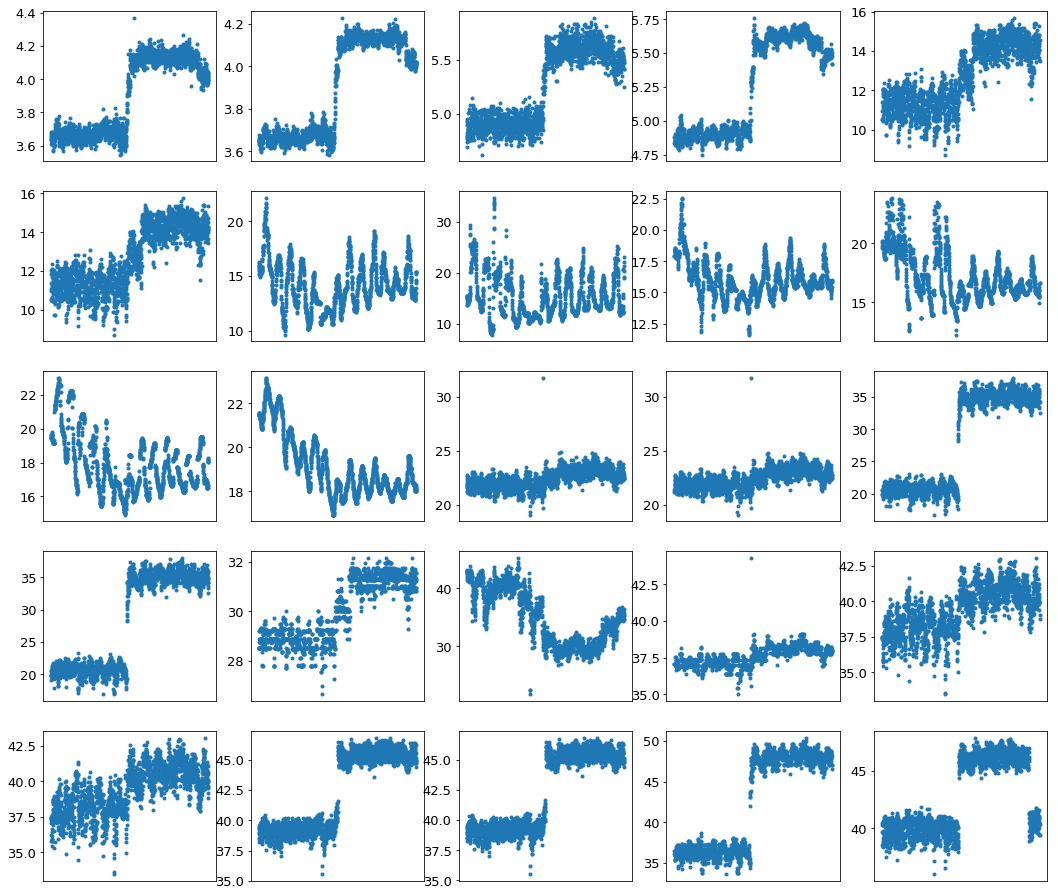

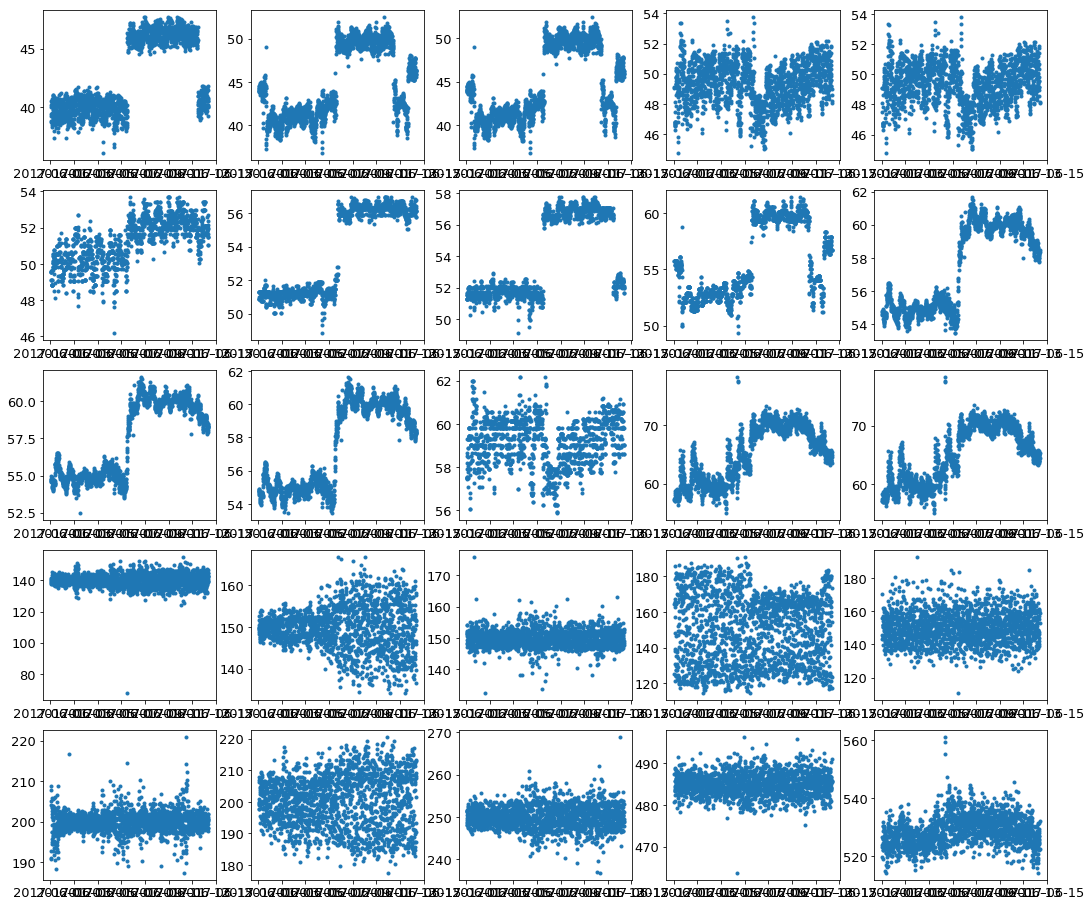

In [12]:
mod_keys = stats_df.index.values

i = 1
plt.figure(1) 
for mkey in mod_keys[:25]:
    plt.subplot(5, 5, i)
    sensor = bms_df[bms_df.module_key == mkey]
    sensor = sensor[["timestamp", "param_value"]]
    sensor = sensor.sort_values("timestamp")
    sensor = sensor[sensor['param_value'] != 'Invalid']
    
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
    
    plt.plot_date("timestamp", "param_value", ".", data=sensor)
    i += 1
plt.savefig('plots/module_samples_var.png')
i = 1
plt.figure(2) 
for mkey in mod_keys[25:]:
    plt.subplot(5, 5, i)
    sensor = bms_df[bms_df.module_key == mkey]
    sensor = sensor[["timestamp", "param_value"]]
    sensor = sensor.sort_values("timestamp")
    plt.plot_date("timestamp", "param_value", ".", data=sensor)
    i += 1

In [12]:
stats_df

,count,mean,std,min,25%,50%,75%,max
module_key,,,,,,,,
S5,1907.0,3.897647,0.226850,3.547020,3.669780,3.977610,4.122690,4.365420
S33,1907.0,3.898965,0.224423,3.585252,3.669465,3.989369,4.127230,4.225651
S8,1907.0,5.250149,0.351410,4.620278,4.904055,5.358314,5.588141,5.884866
S34,1907.0,5.250747,0.345670,4.750976,4.900730,5.391140,5.598971,5.755591
D12,1908.0,12.675047,1.588583,8.722244,11.320517,12.411708,14.205067,15.665213
L6,1907.0,12.675262,1.589541,8.713520,11.329907,12.394001,14.209231,15.751103
S2,1907.0,14.130790,2.096562,9.645120,12.604486,13.842031,15.532761,22.086525
S1,1907.0,15.361403,4.073160,7.878013,12.247164,14.199353,18.278023,34.615437
S3,1907.0,15.978339,1.468139,11.628393,15.031645,15.785500,16.770308,22.530994


### Naive K-Means

Naive k-means clustering based on summary stats of the sensors of varying readings to provide some initial insight. First the elbow method is employed to observe the clusters that explain the most variance in the data set.
(Naive because it doesn't yet account for weekly perodicity, or other factors that might be of significance, that are not yet accounted for)

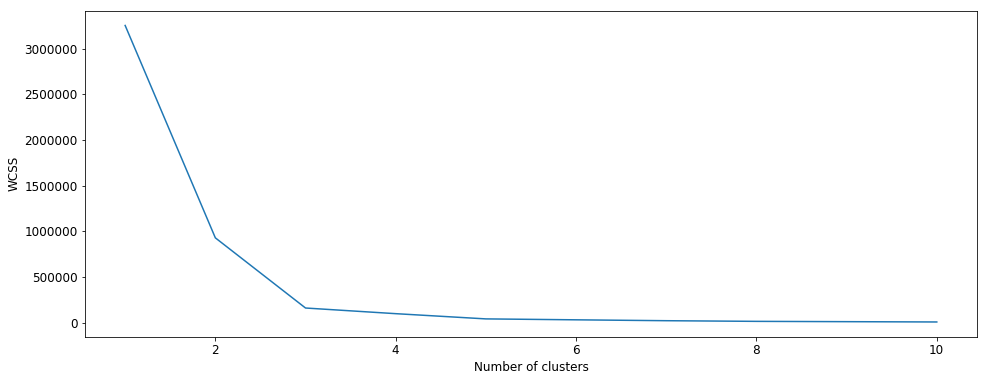

In [14]:
X = stats_df.iloc[:,:].values

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SEED_KMEANS = 42

# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = RANDOM_SEED_KMEANS)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.rcParams["figure.figsize"] = [16, 6]
plt.rcParams['font.size'] = 12
plt.plot(range(1, 11), wcss)
# plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('plots/elbow.png')
plt.show()

__Three__ clusters account for the most variance.

In [15]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
predicted_cluster_series = kmeans.fit_predict(X)
stats_df['cluster'] = predicted_cluster_series
stats_df.sort_index()['cluster']

module_key
D10    0
D11    0
D12    0
D13    0
D14    0
D15    0
D2     0
D20    0
D8     0
D9     0
L1     0
L11    0
L14    0
L3     0
L4     0
L5     0
L6     0
L7     0
L8     0
L9     0
S1     0
S11    0
S12    2
S13    0
S14    2
S15    0
S16    2
S17    0
S18    2
S19    0
S2     0
S20    2
S21    0
S22    2
S23    0
S24    2
S25    0
S26    2
S27    0
S3     0
S33    0
S34    0
S36    1
S39    0
S4     0
S5     0
S6     0
S7     0
S8     0
S9     1
Name: cluster, dtype: int32

In [15]:
# cluster_dict = stats_df[[ 'cluster']].to_dict()

In [16]:
# bms_df_naive_cluster = bms_df[bms_df.module_key.isin(mod_keys)]

In [17]:
# bms_df_naive_cluster.assign(cluster = lambda x: cluster_dict['cluster'][x.module_key])

#### Metadata Join
Arrange it by asset code (join with metadata file) to uniquely ID each sensor. A uniqe key is created by joining the _logger asset code_ and the _module key_. This makes it possible to refer to every sensor uniquely, since module keys alone are not unique.

In [16]:
#creating a key on which to join both DataFrames:

bms_meta_df = bms_meta_df[['Logger Channel', 'Logger Asset Code']]
bms_meta_df['key'] = bms_meta_df['Logger Asset Code'] + "/" + bms_meta_df['Logger Channel']
bms_meta_df.columns = ['device_id', 'asset_code', 'key']
bms_df['key'] = bms_df['device_id'] + "/" + bms_df['module_key']

bms_df = bms_df.merge(bms_meta_df, on='key')

bms_df.head()

,param_name,param_type,param_value,timestamp,device_id_x,module_key,key,device_id_y,asset_code
0,S,1,10.467929,2017-06-01 01:00:00.530,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D12,{A69642A1-3855-479C-89F7-DCB47B48FCC0}/D12,D12,{A69642A1-3855-479C-89F7-DCB47B48FCC0}
1,S,1,10.541347,2017-06-01 01:10:02.447,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D12,{A69642A1-3855-479C-89F7-DCB47B48FCC0}/D12,D12,{A69642A1-3855-479C-89F7-DCB47B48FCC0}
2,S,1,12.145656,2017-06-03 04:00:03.587,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D12,{A69642A1-3855-479C-89F7-DCB47B48FCC0}/D12,D12,{A69642A1-3855-479C-89F7-DCB47B48FCC0}
3,S,1,11.51519,2017-06-02 03:10:03.993,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D12,{A69642A1-3855-479C-89F7-DCB47B48FCC0}/D12,D12,{A69642A1-3855-479C-89F7-DCB47B48FCC0}
4,S,1,11.085073,2017-06-04 05:10:01.657,{A69642A1-3855-479C-89F7-DCB47B48FCC0},D12,{A69642A1-3855-479C-89F7-DCB47B48FCC0}/D12,D12,{A69642A1-3855-479C-89F7-DCB47B48FCC0}


## K-means

As a start, examining similarity as a function of euclidean distance via K-means clustering on the original dataset.

In [17]:
import numpy as np

# use only sensors with varying readings
bms_df = bms_df[bms_df.module_key.isin(mod_keys)]
bms_df['timestamp'] = pd.to_datetime(bms_df['timestamp'])
bms_df['hour'] = bms_df['timestamp'].dt.hour
bms_df['day_of_week'] = bms_df['timestamp'].dt.weekday
bms_df['week_of_year'] = bms_df['timestamp'].dt.weekofyear
bms_df['minute'] = bms_df['timestamp'].dt.minute
bms_df['day'] = bms_df['timestamp'].dt.day
bms_df.sort_values('timestamp')
bms_cluster_df = bms_df[['hour', 'minute', 'day_of_week', 'week_of_year', 'param_value' ]]

# remove Invalid reading
bms_cluster_df = bms_cluster_df[bms_cluster_df['param_value'] != 'Invalid']


#Prepare data for clustering
X = bms_cluster_df.iloc[:,:].values

bms_cluster_df.head()

,hour,minute,day_of_week,week_of_year,param_value
0,1,0,3,22,10.467929
1,1,10,3,22,10.541347
2,4,0,5,22,12.145656
3,3,10,4,22,11.51519
4,5,10,6,22,11.085073


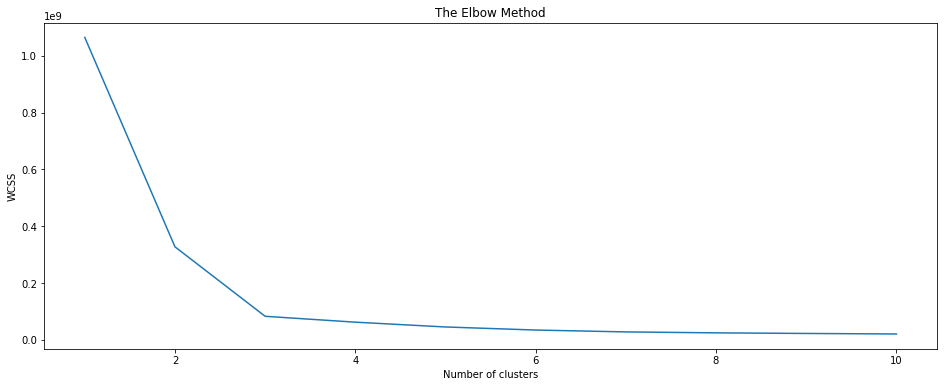

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SEED_KMEANS = 42

# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = RANDOM_SEED_KMEANS)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.rcParams["figure.figsize"] = [16, 6]
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The most variance is also explained by 3 clusters, using euclidean distance as a similarity metric alone.

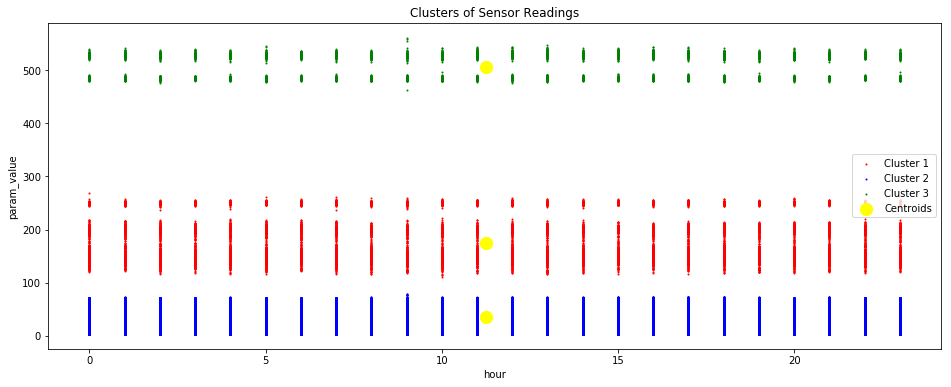

In [19]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 4], s = 1, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 4], s = 1, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 4], s = 1, c = 'green', label = 'Cluster 3')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 4], s = 150, c = 'yellow', label = 'Centroids')
plt.title('Clusters of Sensor Readings')
plt.xlabel('hour')
plt.ylabel('param_value')
plt.rcParams["figure.figsize"] = [16, 6]
plt.legend()
plt.show()

## K-means on weekly aggregated summary statistic dataframe

Comparing the clusters that came out of the k-means clustering for the summary stats data, and the actual bms data, the clustering is about the same. That is, a cluster with mean from 3 - 65, one from 135 - 250, and one from 485+
(extra notes in backup)

making the summary stats across weeks in a month will help to account for some seasonality averages.

In [20]:
bms_df['month_week'] = bms_df['week_of_year'] % 4

In [21]:
st_df2 = bms_df[['module_key', 'param_value', 'month_week']]
st_df2['param_value'] = pd.to_numeric(st_df2['param_value'])
stats_df2 = st_df2.groupby(['module_key', 'month_week'])['param_value'].describe()
stats_df2 = stats_df2[stats_df2['count'].values > 0.0]
stats_df2 = stats_df2.reset_index()
month_stats = []

for i in range(4):
    week_df = stats_df2[stats_df2['month_week'] == i]
    month_stats.append(week_df)

month_stats = [df.set_index('module_key') for df in month_stats]
month_df = pd.concat(month_stats, axis=1)
month_df = month_df.dropna(axis=1, how='any')

month_df = month_df[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']] # to remove month_week category
month_df

E:\Anaconda3\envs\dsci\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,count,count,count,mean,mean,mean,std,std,std,min,...,25%,50%,50%,50%,75%,75%,75%,max,max,max
D10,340.0,566.0,1002.0,50.057633,49.462870,49.063175,1.132693,1.315147,1.471854,47.193794,...,48.041091,50.164860,49.569367,49.125973,50.939654,50.402332,50.194384,52.152664,53.339657,53.763168
D11,340.0,566.0,1002.0,43.954504,39.880313,43.851369,2.811342,0.831826,3.167272,38.935341,...,40.270364,45.534540,39.964071,45.643003,46.255845,40.511045,46.329391,47.545708,41.834824,47.846615
D12,340.0,566.0,1002.0,14.247640,11.254314,12.943962,0.639616,0.699241,1.529530,11.563838,...,11.627983,14.318886,11.277627,13.204414,14.698406,11.828424,14.294520,15.665213,13.106773,15.413822
D13,340.0,566.0,1002.0,45.455003,39.130972,43.050995,0.572935,0.577830,3.035397,44.011322,...,39.621146,45.459524,39.202016,44.874105,45.891637,39.575532,45.573071,46.762287,40.407139,46.776772
D14,340.0,566.0,1002.0,22.999143,21.831804,22.551555,0.558847,0.539003,0.942928,21.299511,...,21.924686,23.005317,21.839502,22.564809,23.406302,22.239810,23.207070,24.446815,23.313395,31.692488
D15,340.0,566.0,1002.0,35.000188,20.577653,29.998449,1.016812,0.897289,6.912096,32.155544,...,21.333210,35.019531,20.633088,34.311867,35.705211,21.212518,35.364183,37.894867,23.111700,37.471611
D2,340.0,566.0,1002.0,59.478080,54.868517,58.225631,0.723895,0.510791,2.450362,57.747532,...,55.393604,59.553039,54.809900,59.639260,59.994040,55.104676,60.155148,61.085217,56.515503,61.683983
D20,340.0,566.0,1002.0,44.811953,41.199636,46.722926,3.210729,1.549324,4.043882,38.598186,...,42.290608,44.705580,40.961492,48.958174,47.217878,41.794453,49.926199,51.306244,48.991066,52.494957
D8,340.0,566.0,1002.0,67.035683,59.958180,67.538342,1.965259,1.986520,4.085009,63.237381,...,64.087164,66.794940,59.593754,69.309761,68.619255,60.886035,70.568737,72.111694,67.140350,78.344894
D9,340.0,566.0,1002.0,40.479107,38.036925,39.738979,0.955789,1.157491,1.546838,37.893322,...,38.665475,40.504078,38.020048,40.020576,41.143042,38.851406,40.881801,43.030262,41.316433,42.998459


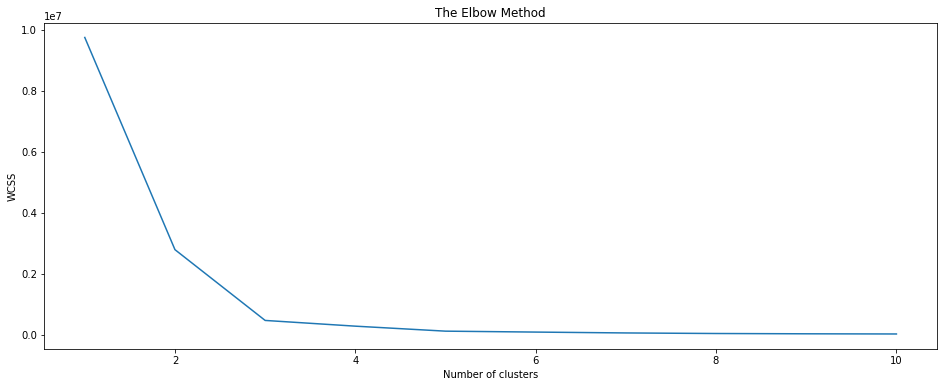

In [22]:
X = month_df.iloc[:,:].values

RANDOM_SEED_KMEANS = 42

# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = RANDOM_SEED_KMEANS)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.rcParams["figure.figsize"] = [16, 6]
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [23]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
predicted = kmeans.fit_predict(X)
predicted_cluster_series = kmeans.fit_predict(X)
stats_df['cluster2'] = predicted_cluster_series
stats_df.sort_index()[['cluster','cluster2']].to_csv("kmeans/jun_clust.csv")
stats_df.sort_index()[['cluster','cluster2']]
# compare predicted clusters across naive k-means, full k-means and original k-means clusters
# stats_df.sort_index()['cluster'] == 

,cluster,cluster2
module_key,,
D10,0,2
D11,0,2
D12,0,0
D13,0,0
D14,0,0
D15,0,0
D2,0,0
D20,0,2
D8,0,0


NB: cluster is for the monthly stats df, and cluster2 for the weekly stats_df

### Visualizing the Clusters

How many sensors fall into each cluster?

In [24]:
for i in range(3):
    print("Sensors in Cluster %d: %d" % (i, stats_df[stats_df['cluster'] == i].shape[0]))
for i in range(3):
    print("Sensors in Cluster2 %d: %d" % (i, stats_df[stats_df['cluster2'] == i].shape[0]))

Sensors in Cluster 0: 40
Sensors in Cluster 1: 2
Sensors in Cluster 2: 8
Sensors in Cluster2 0: 40
Sensors in Cluster2 1: 2
Sensors in Cluster2 2: 8


Numbers match up, but some sensors are differently clustered.

In [25]:
cluster_0_keys = stats_df[stats_df['cluster'] == 0].index
cluster_1_keys = stats_df[stats_df['cluster'] == 1].index
cluster_2_keys = stats_df[stats_df['cluster'] == 2].index

cluster2_0_keys = stats_df[stats_df['cluster2'] == 0].index
cluster2_1_keys = stats_df[stats_df['cluster2'] == 1].index
cluster2_2_keys = stats_df[stats_df['cluster2'] == 2].index

##### Cluster 0

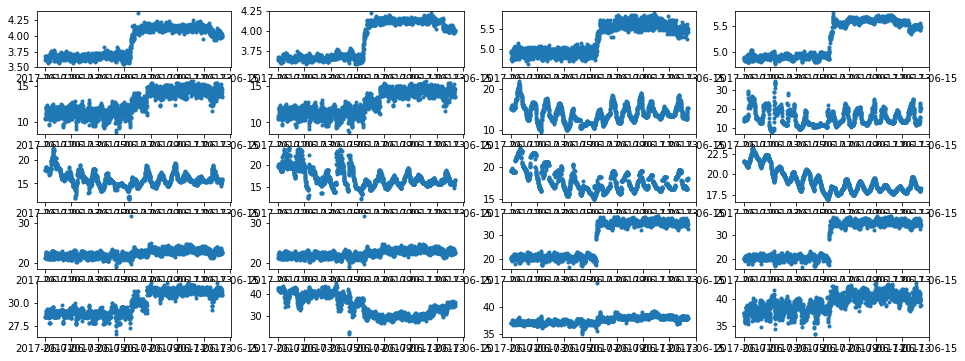

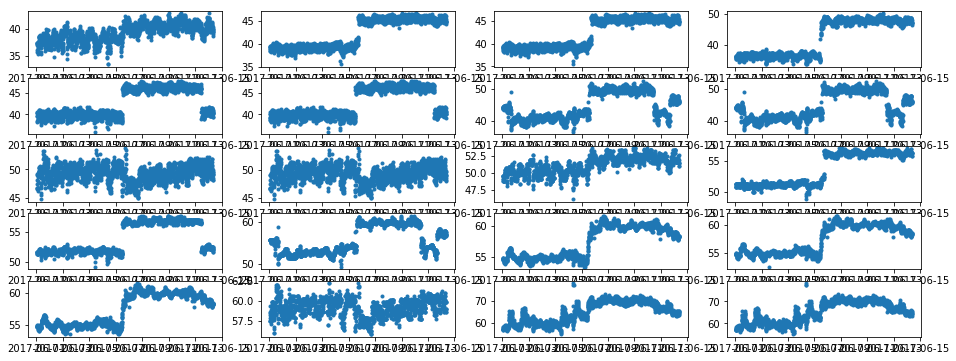

In [26]:
i = 1

plt.figure(1)
for mkey in cluster_0_keys[:20]:
    plt.subplot(5, 4, i)
    sensor = bms_df[bms_df.module_key == mkey]
    sensor = sensor[["timestamp", "param_value"]]
    sensor = sensor.sort_values("timestamp")
    sensor = sensor[sensor['param_value'] != 'Invalid']
    plt.plot_date("timestamp", "param_value", ".", data=sensor)
    i += 1
# plt.savefig('plots/module_samples_var.png')
i = 1
plt.figure(2) 
for mkey in cluster_0_keys[20:]:
    plt.subplot(5, 4, i)
    sensor = bms_df[bms_df.module_key == mkey]
    sensor = sensor[["timestamp", "param_value"]]
    sensor = sensor.sort_values("timestamp")
    plt.plot_date("timestamp", "param_value", ".", data=sensor)
    i += 1

##### Cluster 1

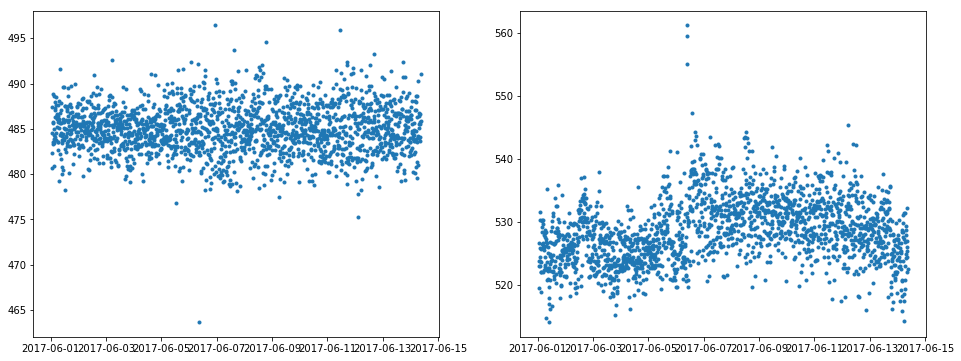

In [27]:
i = 1

plt.figure(1)
for mkey in cluster_1_keys:
    plt.subplot(1, 2, i)
    sensor = bms_df[bms_df.module_key == mkey]
    sensor = sensor[["timestamp", "param_value"]]
    sensor = sensor.sort_values("timestamp")
    sensor = sensor[sensor['param_value'] != 'Invalid']
    plt.plot_date("timestamp", "param_value", ".", data=sensor)
    i += 1
plt.savefig('plots/sample_cluster_one.png')

##### Cluster 2

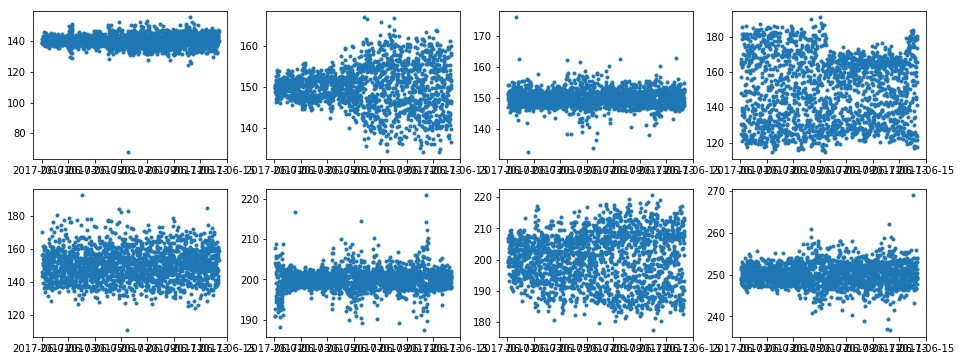

In [28]:
i = 1

plt.figure(1)
for mkey in cluster_2_keys:
    plt.subplot(2, 4, i)
    sensor = bms_df[bms_df.module_key == mkey]
    sensor = sensor[["timestamp", "param_value"]]
    sensor = sensor.sort_values("timestamp")
    sensor = sensor[sensor['param_value'] != 'Invalid']
    plt.plot_date("timestamp", "param_value", ".", data=sensor)
    i += 1
plt.savefig('plots/sample_cluster_two.png')

In [29]:
bms_df_cluster_0 = bms_df[bms_df["module_key"].isin(cluster_0_keys)]
bms_df_cluster_1 = bms_df[bms_df["module_key"].isin(cluster_1_keys)]
bms_df_cluster_2 = bms_df[bms_df["module_key"].isin(cluster_2_keys)]

In [30]:
bms_df_cluster_0 = bms_df_cluster_0[bms_df_cluster_0['param_value'] != "Invalid"]
bms_df_cluster_1 = bms_df_cluster_1[bms_df_cluster_1['param_value'] != "Invalid"]
bms_df_cluster_2 = bms_df_cluster_2[bms_df_cluster_2['param_value'] != "Invalid"]

In [33]:

# bms_df_cluster_0.select_dtypes(include=[np.number], exclude=None)
# bms_df_cluster_0['param_value'].values - 1

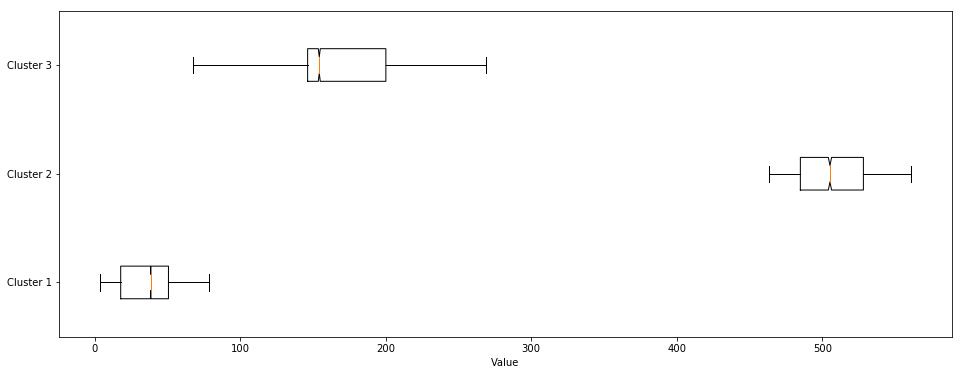

In [32]:
cluster_boxes = [pd.to_numeric(bms_df_cluster_0['param_value']), pd.to_numeric(bms_df_cluster_1['param_value']),
                 pd.to_numeric(bms_df_cluster_2['param_value'])]
plt.boxplot(cluster_boxes, labels=["Cluster 1", "Cluster 2", "Cluster 3"], notch=True, vert=False)
# plt.rcParams['font.size'] = 13
plt.xlabel("Value")
plt.savefig("plots/cluster_box.png")
plt.show()

## DTW

Instead, compute a distance matrix using DTW, then run hierarchical clustering such as single-link. In contrast to k-means, the series may even have different length.

The dtw_df is the general energy vector data frame. Each row is a chronological ordering of readings from a unique sensor.

!DTW as preprocessing. As post-clstering technique


In [33]:
dtw_df = bms_df[['key', 'param_value']]
dtw_df = dtw_df[dtw_df['param_value'] != 'Invalid']
dtw_df.head(10)

pivot = dtw_df.pivot(columns='key', values='param_value')
matrix = pivot.apply(lambda y: [a  for a in y if pd.notnull(a)])

#### Creating the DTW Distance Matrix

In [34]:
from dtaidistance import dtw
import pickle
import os

dtw_df = pd.DataFrame(matrix.tolist(), dtype=np.float32)
dtw_df.head()

num_sensors = dtw_df.shape[0] # this may be good to have, going forward.

# this is very slow. Expect about an hour and twenty minutes for one BMS file
# If there is no pickle (.p) file in the current directory, create it:
if not os.path.exists("dtw_distance_matrix.p"):
    start_time = timeit.default_timer()
    d_matrix = dtw.distance_matrix(dtw_df)
    elapsed = timeit.default_timer() - start_time
    print("%.2f seconds" % elapsed)
    # to cache the data for fast access later.
    pickle.dump(d_matrix, open( "dtw_distance_matrix.p", "wb" ) )
else:
    # load distance matrix from pickle file.
    d_matrix = pickle.load(open( "dtw_distance_matrix.p", "rb" ))
    print("Distance Matrix Loaded from Pickle.")


DTW C variant not available.

If you want to use the C libraries (not required, depends on cython), then run `cd E:\Anaconda3\envs\dsci\lib\site-packages\dtaidistance\..;python3 setup.py build_ext --inplace`.


Distance Matrix Loaded from Pickle.


### Hierarchical clustering with Dendrograms

In [35]:
from sklearn.preprocessing import StandardScaler

# Standardizing the data
d_matrix[d_matrix == np.inf] = 0
sc_X = StandardScaler()
d_matrix_scaled = sc_X.fit_transform(d_matrix)

##### Optimal cluster number, with DTW adjustment

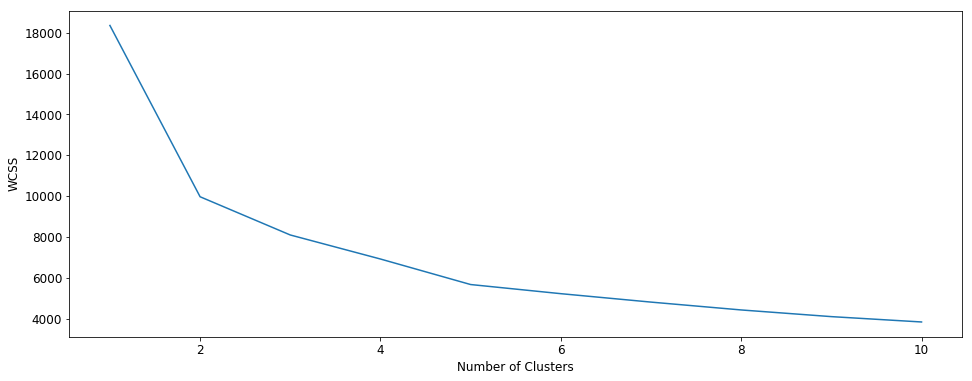

In [36]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(d_matrix_scaled)
    wcss.append(kmeans.inertia_)

plt.rcParams["figure.figsize"] = [16, 6]
plt.rcParams['font.size'] = 12
plt.plot(range(1, 11), wcss)
# plt.title('The Elbow Method (w/ DTW)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.savefig('plots/dtw_elbow.png')
plt.show()

About 5 clusters account for the most variance, now that dynamic time warping has been applied to the data. 

#### Ward Linkage

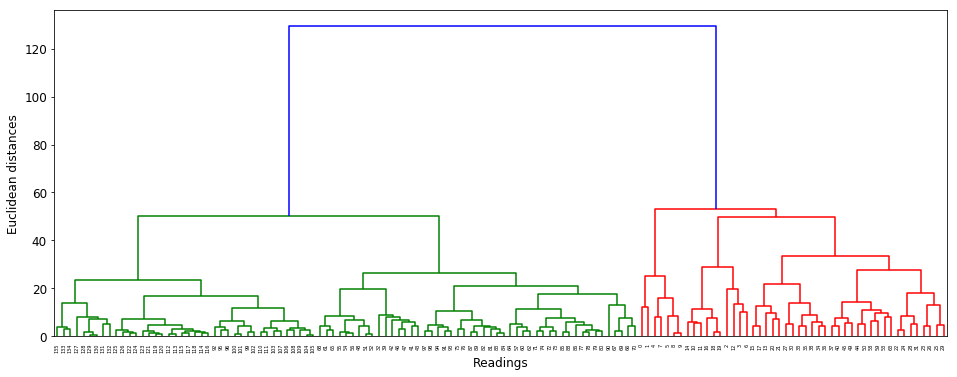

In [37]:
import scipy.cluster.hierarchy as sch

# Dendrogram using Ward Linkage
dendrogram = sch.dendrogram(sch.linkage(d_matrix_scaled, method = 'ward'))
# plt.title('Dendrogram')
plt.xlabel('Readings')
plt.ylabel('Euclidean distances')
plt.rcParams["figure.figsize"] = [16, 6]
plt.savefig('plots/ward_linkage.png')
plt.show()

Elbow method, now with dynamic time warping matrix:

#### single-linkage

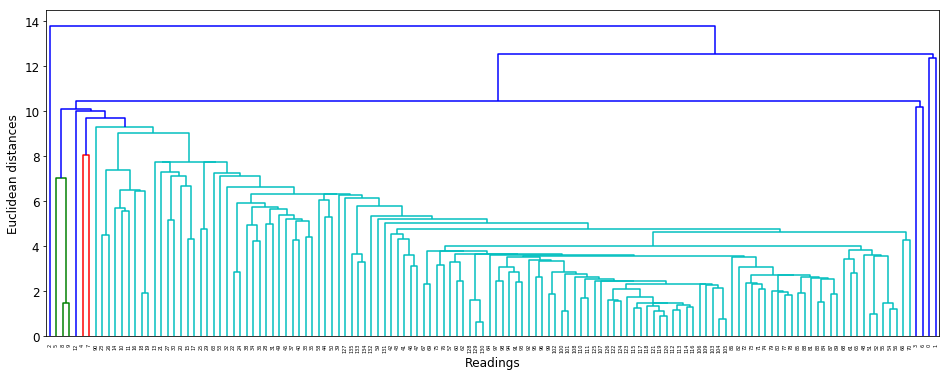

In [38]:
dendrogram = sch.dendrogram(sch.linkage(d_matrix_scaled, method = 'single'))
# plt.title('Dendrogram')
plt.xlabel('Readings')
plt.ylabel('Euclidean distances')
plt.rcParams["figure.figsize"] = [16, 6]
plt.savefig('plots/single_linkage.png')
plt.show()

#### Weighted linkage

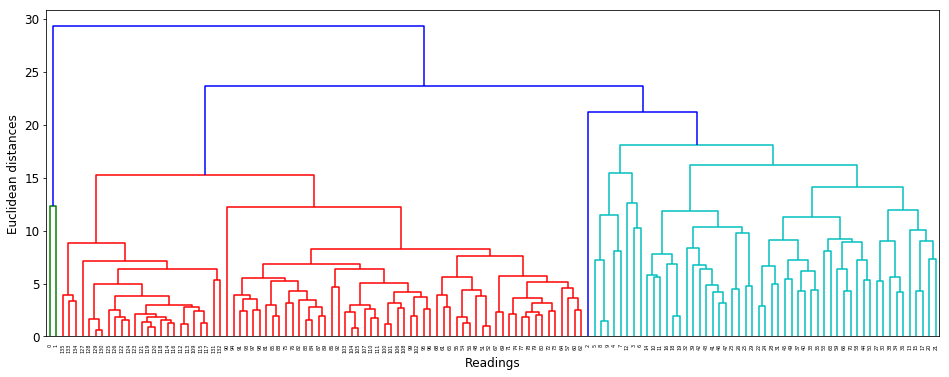

In [39]:
dendrogram = sch.dendrogram(sch.linkage(d_matrix_scaled, method = 'weighted'))
# plt.title('Dendrogram')
plt.xlabel('Readings')
plt.ylabel('Euclidean distances')
plt.rcParams["figure.figsize"] = [16, 6]
plt.savefig('plots/weighted_linkage.png')
plt.show()

#### Complete Linkage

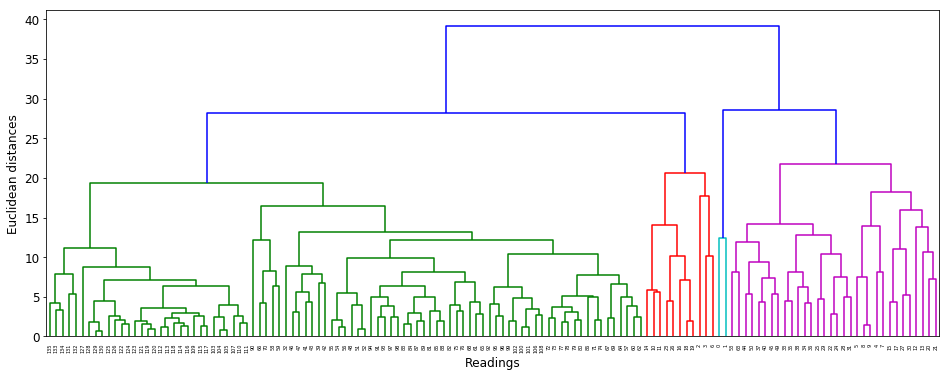

In [40]:
dendrogram = sch.dendrogram(sch.linkage(d_matrix_scaled, method = 'complete'))
# plt.title('Dendrogram')
plt.xlabel('Readings')
plt.ylabel('Euclidean distances')
plt.rcParams["figure.figsize"] = [16, 6]
plt.savefig('plots/complete_linkage.png')
plt.show()

### Notes

The linkage function chosen has a significant effect on the kinds of clusters observed, at a given threshold. Experiment further with different linkage function and threshold clusters.

#### Visualizing Clusters over Time

Choosing a cluster size of 5:

In [48]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'complete')
y_hc = hc.fit_predict(d_matrix_scaled)
# dtw_df['cluster'] = y_hc
dtw_df.shape

(50, 1908)

In [ ]:
cluster_1_df = dtw_df[dtw_df['cluster'] == 0]
cluster_2_df = dtw_df[dtw_df['cluster'] == 1]
cluster_3_df = dtw_df[dtw_df['cluster'] == 2]
cluster_4_df = dtw_df[dtw_df['cluster'] == 3]
cluster_5_df = dtw_df[dtw_df['cluster'] == 4]

print("%d of %d sensors belong to cluster 1" % (cluster_1_df.shape[0], num_sensors))
print("%d of %d sensors belong to cluster 2" % (cluster_2_df.shape[0], num_sensors))
print("%d of %d sensors belong to cluster 3" % (cluster_3_df.shape[0], num_sensors))
print("%d of %d sensors belong to cluster 4" % (cluster_4_df.shape[0], num_sensors))
print("%d of %d sensors belong to cluster 5" % (cluster_5_df.shape[0], num_sensors))

##### Cluster 1

In [ ]:
cluster_1_df.iloc[:,:-1].plot(legend=False, title="Cluster 1")

##### Cluster 2

In [ ]:
cluster_2_df.iloc[:,:-1].plot(legend=False, title="Cluster 2")

##### Cluster 3

In [ ]:
cluster_3_df.iloc[:,:-1].plot(legend=False, title="Cluster 3")

##### Cluster 4

In [ ]:
cluster_4_df.iloc[:,:-1].plot(legend=False, title="Cluster 4")

##### Cluster 5

In [ ]:
cluster_5_df.iloc[:,:-1].plot(legend=False, title="Cluster 5")

In [ ]:
cluster_5_df.shape

## GMM with EM



In [49]:
from sklearn import mixture

# Fit a Gaussian mixture with EM using N components
# The BIC score will determine the optimal number of clusters

N = 7
scores = []
for n in range(3,N+1):
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='full', random_state=412).fit(d_matrix_scaled)
    scores.append(gmm.bic(d_matrix_scaled))

for i in range(len(scores)):
    print("BIC score for GMM with EM, N = %d ==> %.2f" % (i+3, scores[i]))

# Number of components with the best BIC score
components = scores.index(min(scores)) + 3
print("Optimal number of components: %d" % components)
gmm = mixture.GaussianMixture(n_components=components, covariance_type='full', random_state=412).fit(d_matrix_scaled)

####
# probabilities of belonging to each assigned class (p = odds/1 + odds):
np.exp(gmm.score_samples(d_matrix_scaled))/(1 + np.exp(gmm.score_samples(d_matrix_scaled)))

BIC score for GMM with EM, N = 3 ==> 4519.02
BIC score for GMM with EM, N = 4 ==> 30036.32
BIC score for GMM with EM, N = 5 ==> 70256.96
BIC score for GMM with EM, N = 6 ==> 103249.59
BIC score for GMM with EM, N = 7 ==> 143869.21
Optimal number of components: 3


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.])

## DBSCAN

Performing a DBSCAN iterating over different parameter combinations that identify 3 or more clusters.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

params = []

for i in range(1, 50):
    for j in range(5,50):
        db = DBSCAN(eps=i, min_samples=j).fit(d_matrix_scaled) # explore non-euclidean distance measures
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters >= 3:
            print("eps: %.2f, min_samples: %.2f\nN = %d" % (i, j, n_clusters))
            params.append((i,j,n_clusters))

#print('Estimated number of clusters: %d' % n_clusters_)
# d_matrix_scaled

## CONS: very sensitive to parameter choice

print("%d possible parameter combination(s)" % len(params))
db = DBSCAN(eps=params[0][0], min_samples=params[0][1]).fit(d_matrix_scaled)
db.fit_predict(d_matrix_scaled)

Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1. eps = 5 and min_samples = 3 tends to give the least noisy labeling.

## Conclusion

While some measures have been a bit arbitrary (dendrograms with their respective distance measures), the cluster analysis altogether gives good reason to believe that the expected number of intrinsic clusters is __three__ to __five__.

# Functional Data Analysis

What we're trying to establish here is a way to quanify meaninful patterns in sensor readings that reflect the variation in the wider system of sensors. The approach is to represent the readings of each sensor (per cluster) by a single function of time, and then to use the functions derived for more in-depth analysis.

First, the mean functions of the data are estimated. The average is taken across the clusters so that each cluster can be represented as one distinct curve.

In [ ]:
cluster_1_avg_df = cluster_1_df.iloc[:,:-1]
cluster_2_avg_df = cluster_2_df.iloc[:,:-1]
cluster_3_avg_df = cluster_3_df.iloc[:,:-1]
cluster_4_avg_df = cluster_4_df.iloc[:,:-1]
cluster_5_avg_df = cluster_5_df.iloc[:,:-1]

cluster_1_avg_df = cluster_1_avg_df.mean(axis=1)
cluster_2_avg_df = cluster_2_avg_df.mean(axis=1)
cluster_3_avg_df = cluster_3_avg_df.mean(axis=1)
cluster_4_avg_df = cluster_4_avg_df.mean(axis=1)
cluster_5_avg_df = cluster_5_avg_df.mean(axis=1)

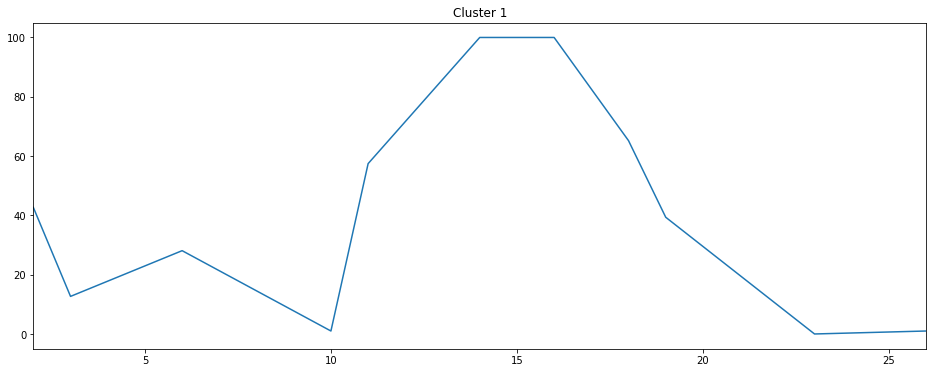

In [101]:
cluster_1_avg_df.plot(title="Cluster 1")

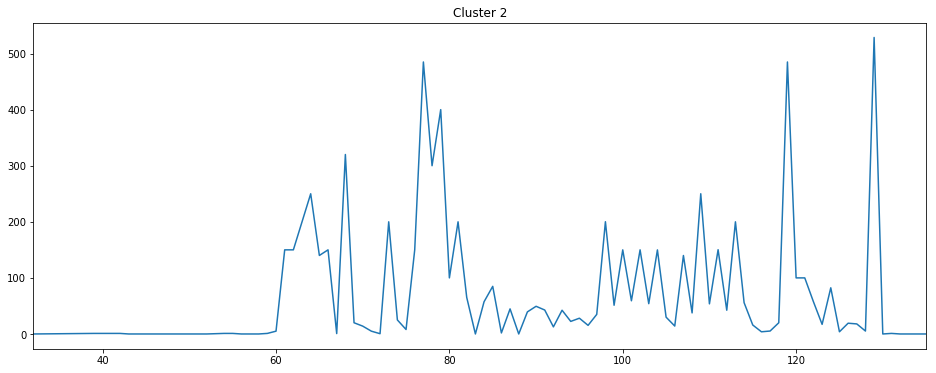

In [93]:
cluster_2_avg_df.plot(title="Cluster 2")

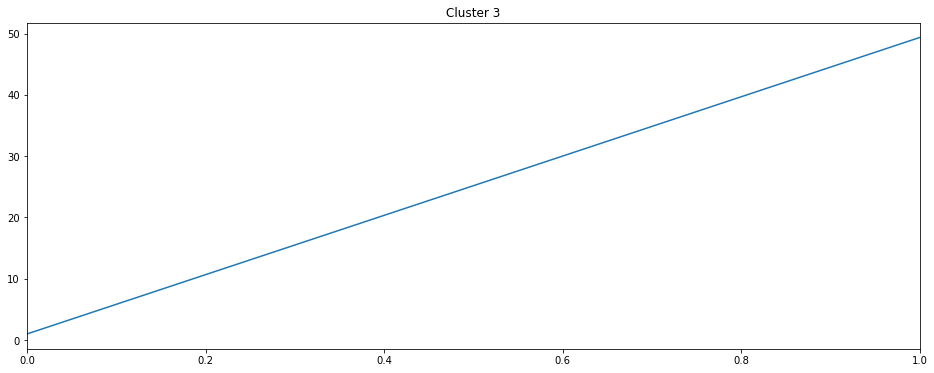

In [94]:
cluster_3_avg_df.plot(title="Cluster 3")

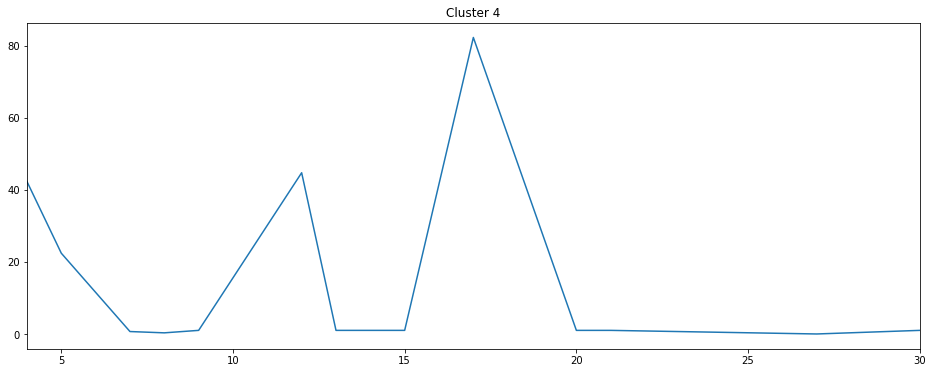

In [95]:
cluster_4_avg_df.plot(title="Cluster 4")

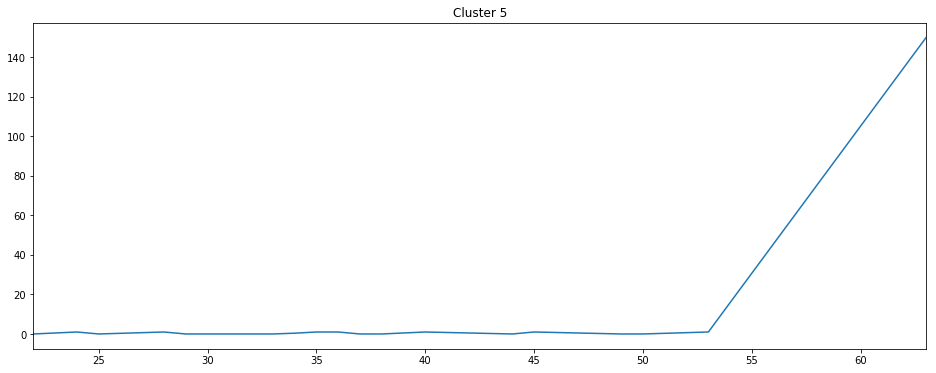

In [96]:
cluster_5_avg_df.plot(title="Cluster 5")

#### Transformation

In [97]:
# plt.plot(np.sqrt(cluster_4_avg_df).mean(axis=1))

#### Curve Smoothing

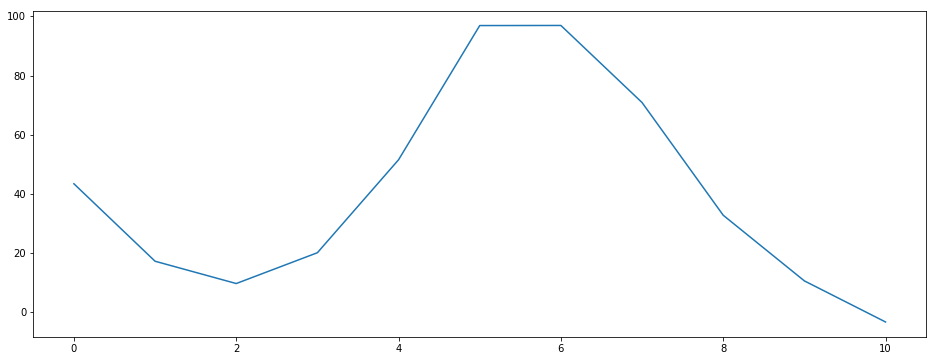

In [99]:
from scipy.signal import medfilt, savgol_filter

# plt.plot(medfilt(cluster_1_avg_df) # median filter
plt.plot(savgol_filter(cluster_1_avg_df, window_length=5, polyorder=2)) # Savitzky-Golay filter
# plt.plot(np.fft.fft(cluster_1_avg_df)) # fourier transformation

In [102]:
cluster_1_avg_df

2      42.691750
3      12.675047
6      28.095106
10      1.000000
11     57.452946
14    100.000000
16    100.000000
18     65.200150
19     39.365959
23      0.000000
26      1.000000
dtype: float32